In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
import requests

import datetime
import time
from chinese_calendar import is_holiday
import calendar

from pandas.api.types import CategoricalDtype

In [2]:
%matplotlib inline

In [3]:
df_user_order_detail = pd.read_csv(r'../input/car8865/用户基础数据.csv',
                              dtype={'trade_order_id':object,'uid':object,'gid':object,'passenger_phone':object,'platform':object,
                                    'service_type':int,'service_type_name':object,'order_status':int,'order_status_name':object,
                                    'order_day':object,'book_day':object,'order_car_type_id':int,'order_car_type_name':object,
                                    'city_code':object,'city_name':object,'channel_id':int,'channel_name':object,
                                    'first_token_driver_taken_type':object,'first_token_driver_taken_type':object,'order_car_type_id':int,
                                     'order_car_type_name':object,'source_type':int,'source_type_name':object},encoding='utf-8')

In [4]:
df_user_order_detail.head()

,trade_order_id,uid,gid,passenger_phone,platform,service_type,service_type_name,order_status,order_status_name,order_day,...,city_code,city_name,channel_id,channel_name,first_taken_driver_taken_type,first_taken_driver_taken_type_name,order_car_type_id.1,order_car_type_name.1,source_type,source_type_name
0,E181619485232,868385039047457,BB7C5279-95E1-DA88-EC0D-9A358E56AB73,186VU265589,Q,3,城市交通（时租）,7,已确认款项,2018-08-11,...,sanya,三亚,60,Android,100,OTA司机接单,99,出租车,12,OTA
1,E181645360215,E7663F36-6C35-4DDA-BEB3-2897F4ED35BC,69093625-85FA-A7B7-F485-0C8AB5404A88,139svlo3695,Q,3,城市交通（时租）,7,已确认款项,2018-09-06,...,shanghai_city,上海,80,iPhone,100,OTA司机接单,5,商务型,12,OTA
2,E181680198260,866229036251187,9AA77171-6B71-0946-0D7A-A21D4DCE2873,186r8ar1007,Q,3,城市交通（时租）,7,已确认款项,2018-10-11,...,wuhan,武汉,60,Android,100,OTA司机接单,99,出租车,12,OTA
3,E181781813380,866693026884317,0EC31567-3910-FA5F-4B13-B1C8FB262628,138gNTQ9157,Q,3,城市交通（时租）,8,取消,2019-01-20,...,nanjing,南京,60,Android,100,OTA司机接单,99,出租车,12,OTA
4,E181787631459,273ECCB0-AA83-4766-8013-C2D22DF0D6A0,97FE372C-B013-A68E-7A17-A44FEAF7E46A,182tpRS3656,Q,2,接机,8,取消,2019-01-26,...,shenyang,沈阳,80,iPhone,100,OTA司机接单,2,舒适型,12,OTA


In [5]:
df_user_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
trade_order_id                        10000 non-null object
uid                                   10000 non-null object
gid                                   10000 non-null object
passenger_phone                       10000 non-null object
platform                              10000 non-null object
service_type                          10000 non-null int32
service_type_name                     10000 non-null object
order_status                          10000 non-null int32
order_status_name                     10000 non-null object
order_day                             10000 non-null object
book_day                              10000 non-null object
order_car_type_id                     10000 non-null int32
order_car_type_name                   10000 non-null object
order_order_class_id                  10000 non-null int64
order_order_class_name                10000 non-null obj

In [6]:
df_user_order_detail.duplicated().value_counts()

False    10000
dtype: int64

In [7]:
df_na = df_user_order_detail[df_user_order_detail.apply(lambda x:x==0) | (df_user_order_detail.apply(lambda x:x==0))].dropna(axis=0,how='all')
df_na.shape

(0, 25)

In [8]:
df_user_order_detail.drop(columns=['order_car_type_id.1','order_car_type_name.1'],inplace=True)

In [9]:
df_user_order_detail.shape

(10000, 23)

In [10]:
def date_extension(row):     # 如有必要，可通过ProcessPoolExecutor加速
    use_immediate = 1 if row['order_day'] == row['book_day'] else 0
    order_date_tuple = time.strptime(row['order_day'],'%Y-%m-%d')[:3]
    book_date_tuple = time.strptime(row['book_day'],'%Y-%m-%d')[:3]
#     order_month = month_short_list[order_date_tuple[1]-1]
    order_month = order_date_tuple[1]
#     book_month = month_short_list[book_date_tuple[1]-1]
    book_month = book_date_tuple[1]
    r_order_date = 1 if is_holiday(datetime.date(order_date_tuple[0],order_date_tuple[1],order_date_tuple[2])) else 0
    r_book_date = 1 if is_holiday(datetime.date(book_date_tuple[0],book_date_tuple[1],book_date_tuple[2])) else 0
    return r_order_date,r_book_date,use_immediate,order_month,book_month

In [11]:
df_user_order_detail[['is_bookdate_holiday','is_orderdate_holiday','use_immediate','order_month','book_month']] = df_user_order_detail.apply(date_extension,axis=1,result_type='expand')

In [12]:
df_user_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
trade_order_id                        10000 non-null object
uid                                   10000 non-null object
gid                                   10000 non-null object
passenger_phone                       10000 non-null object
platform                              10000 non-null object
service_type                          10000 non-null int32
service_type_name                     10000 non-null object
order_status                          10000 non-null int32
order_status_name                     10000 non-null object
order_day                             10000 non-null object
book_day                              10000 non-null object
order_car_type_id                     10000 non-null int32
order_car_type_name                   10000 non-null object
order_order_class_id                  10000 non-null int64
order_order_class_name                10000 non-null obj

In [11]:
df_user_order_detail[['is_bookdate_holiday','is_orderdate_holiday','use_immediate','order_month','book_month']]

,is_bookdate_holiday,is_orderdate_holiday,use_immediate,order_month,book_month
0,1,1,1,8,8
1,0,0,1,9,9
2,0,0,1,10,10
3,1,1,1,1,1
4,1,0,0,1,2
...,...,...,...,...,...
9995,0,0,0,8,8
9996,1,1,0,10,10
9997,0,0,0,1,1
9998,0,0,1,5,5


In [12]:
df_user_order_detail['order_day'].max()     # 2019-06-06
df_user_order_detail['order_day'].min()     # 2018-06-06

'2018-06-06'

In [13]:
plt.rcParams['font.sans-serif']=['SimHei']

In [13]:
# 根据用车月份手动指定顺序，尝试过数字，英文，中文字设置自定义排序，均无法满足要求

In [14]:
# se_order_month = pd.CategoricalDtype(['七月','八月','九月','十月','十一月','十二月','一月','二月','三月','四月','五月','六月'],ordered=True)

In [15]:
# df_user_order_detail['book_month'].astype(se_order_month,inplace=True)

In [16]:
# df_user_order_detail.sort_values('book_month',ascending=True)

In [218]:
# def se_book_time_ordered(se):
#     print(se)
#     se_new = pd.concat(se.sort_index()[6:],se.sort_index()[:6])
#     return se_new

In [14]:
df_service_type_match_name = pd.read_csv(r'../input/car8865/服务类型数据.csv',usecols=['service_type','service_type_name'],
                                         dtype={'servcie_type':int,'servcie_type_name':object})
service_type_list = df_user_order_detail['service_type'].value_counts().index.to_list()
service_type_name_list = df_service_type_match_name.query('service_type in @service_type_list').sort_values('service_type')['service_type_name']
service_type_name_list

0          送机
1          接机
2    城市交通（时租）
3          送站
4          接站
Name: service_type_name, dtype: object

In [15]:
df_service_type_each_month = df_user_order_detail.groupby(['service_type','order_month']).count()['trade_order_id']

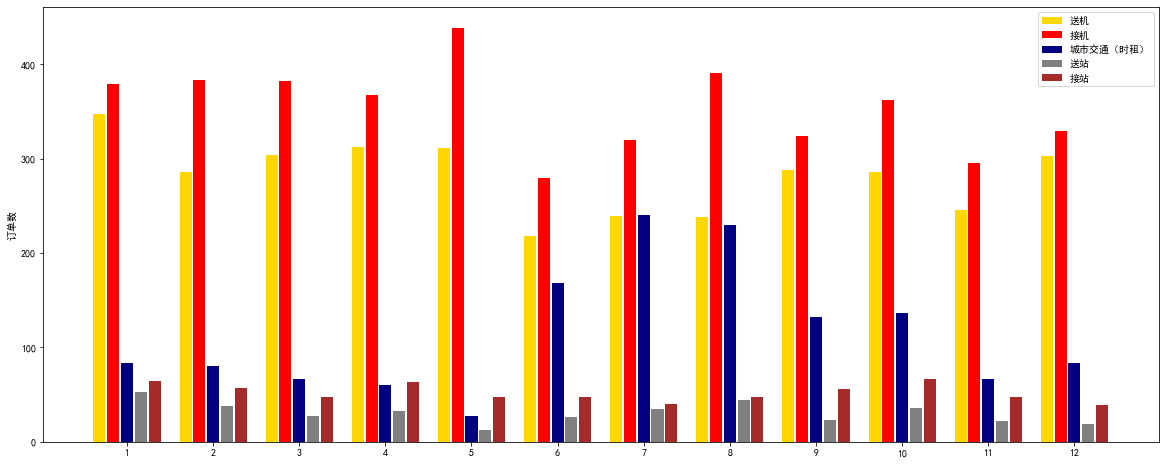

In [16]:
plt.figure(figsize=(20,8))
x = np.arange(len(df_service_type_each_month.xs(1)))
width = 0.14
color_list = ['gold','red','navy','gray','brown']
label_list = service_type_name_list
for i,se_ind in enumerate(range(-2,3)):
    rect1 = plt.bar(x+(width+0.02)*se_ind,df_service_type_each_month.xs((i+1)).values,width,label=label_list[i],color=color_list[i])
plt.xticks(x,labels=df_service_type_each_month.xs(1).index)
plt.ylabel('订单数')
plt.legend(loc='best')

##### 1月送机和送站单数高于其他月份（春运？）
##### 租车往来机场业务明显多于租车往来车站业务，而接机在所有订单类型中占比最高；
##### 备注：6月有订单正在进行中；

In [17]:
list_order_city_top10 = df_user_order_detail['city_name'].value_counts().head(10).index.to_list()
list_order_city_top10

['北京', '上海', '成都', '西安', '重庆', '广州', '三亚', '深圳', '杭州', '昆明']

In [18]:
df_order_cities_each_type = df_user_order_detail.query('city_name in @list_order_city_top10').groupby(['service_type','city_name']).count()['trade_order_id']
# df_order_cities_each_type
df_service_kind_each_city = df_user_order_detail.query('city_name in @list_order_city_top10').groupby(['city_name','service_type']).count()['trade_order_id']
# df_service_kind_each_city

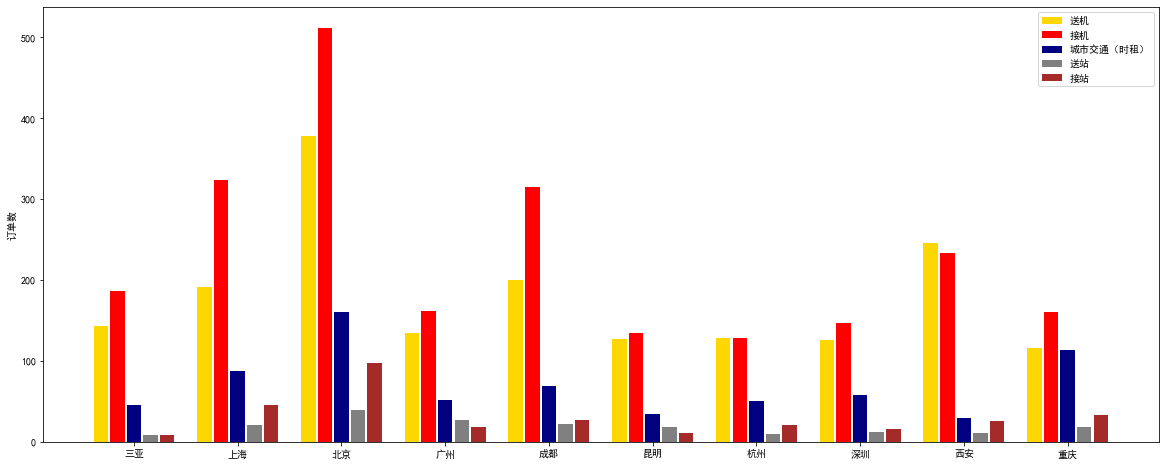

In [19]:
plt.figure(figsize=(20,8))
x = np.arange(len(df_order_cities_each_type.xs(1)))
width = 0.14
color_list = ['gold','red','navy','gray','brown']
label_list = service_type_name_list
for i,se_ind in enumerate(range(-2,3)):
    rect1 = plt.bar(x+(width+0.02)*se_ind,df_order_cities_each_type.xs((i+1)).values,width,label=label_list[i],color=color_list[i])
plt.xticks(x,labels=df_order_cities_each_type.xs(5).sort_index().index.to_list())
plt.ylabel('订单数')
plt.legend(loc='best')

In [20]:
df_user_order_detail[df_user_order_detail['service_type']==3]['city_name'].value_counts().head(10)     # 城市交通订车排名前十的城市

北京    160
重庆    114
上海     88
成都     69
深圳     58
广州     52
杭州     50
三亚     46
昆明     35
厦门     34
Name: city_name, dtype: int64

In [21]:
df_user_order_detail.query('city_name == "昆明" & (book_month == 7)')['service_type_name'].value_counts()

城市交通（时租）    12
送机          12
接机           7
送站           3
接站           1
Name: service_type_name, dtype: int64

In [22]:
df_user_order_detail[df_user_order_detail['city_name']=='杭州']['book_month'].value_counts().sort_index()

1     32
2     31
3     17
4     25
5     28
6     31
7     39
8     31
9     24
10    32
11    26
12    21
Name: book_month, dtype: int64

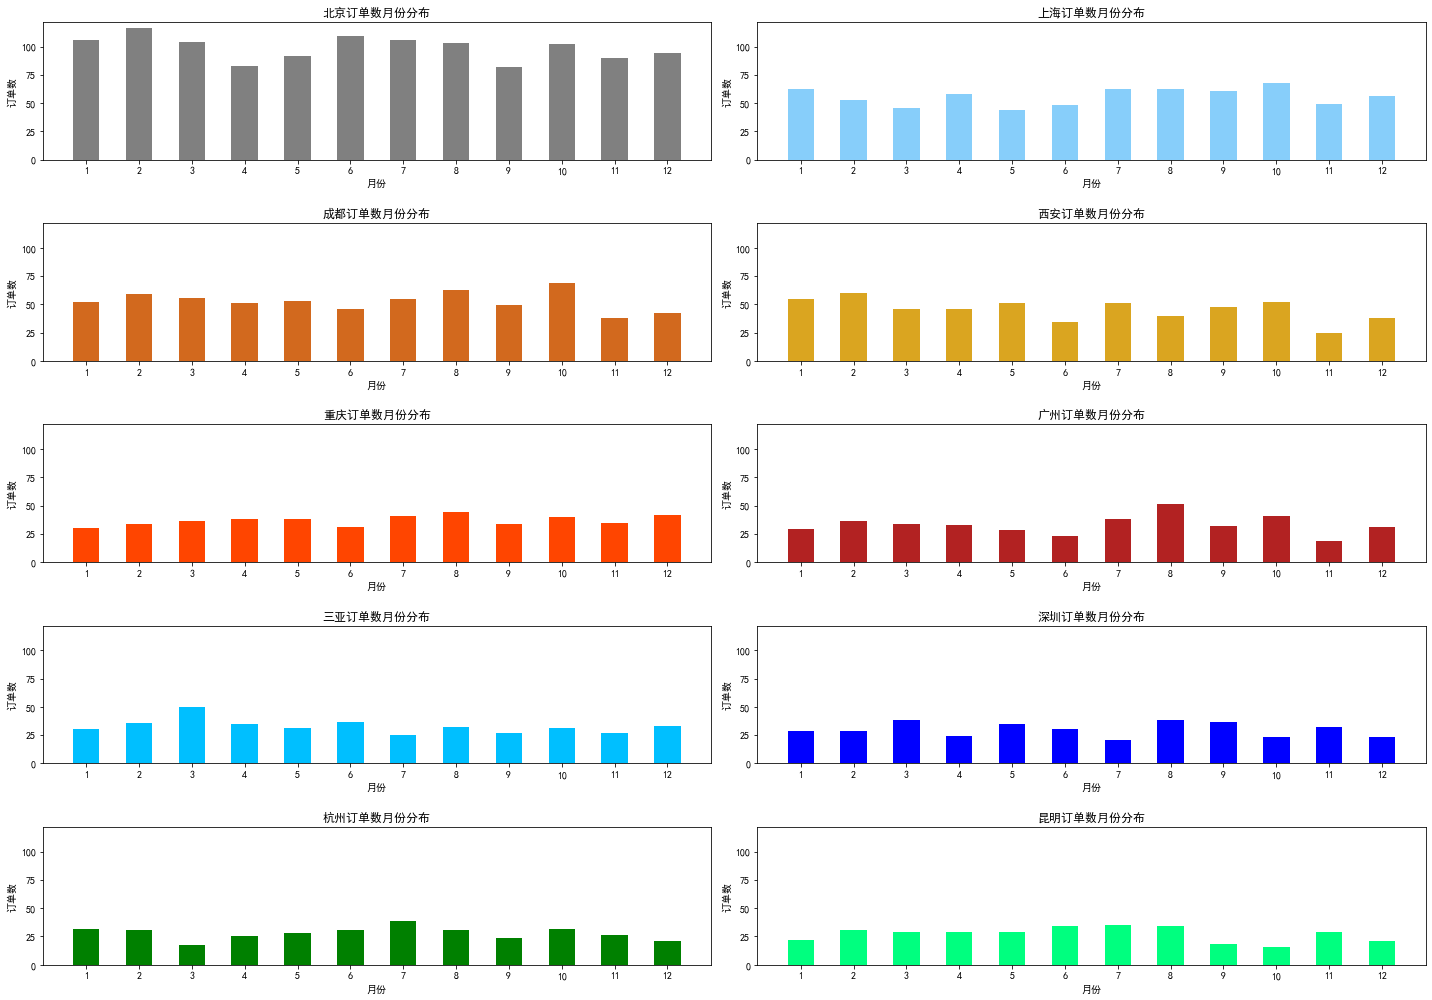

In [23]:
fig = plt.figure(figsize=(20,14))
label_list = list_order_city_top10
color_list = ['grey','lightskyblue','chocolate','goldenrod','orangered','firebrick','deepskyblue','blue','green','springgreen']
ax = None
for j,city in enumerate(list_order_city_top10):
    if ax is None:
        ax = fig.add_subplot(5,2,j+1)
    else:
        ax = fig.add_subplot(5,2,j+1,sharex=ax,sharey=ax)
    x = df_service_type_each_month.xs(1).index.to_list()
    y = df_user_order_detail[df_user_order_detail['city_name']==city]['book_month'].value_counts().sort_index()
    plt.bar(x,y,color=color_list[j],label=label_list[j],width=0.5)
    plt.xticks(x)
    plt.ylabel('订单数')
    plt.xlabel('月份')
    plt.title(f'{city}订单数月份分布')
fig.tight_layout(h_pad=2)

In [24]:
df_service_type_each_city = df_user_order_detail.groupby('city_name')['service_type_name'].agg([('order_total','count'),
                                               ('order_air_send',lambda x:(x=='送机').sum()),
                                               ('order_air_pickup',lambda x:(x=='接机').sum()),
                                               ('order_urban_traffic',lambda x:(x=='城市交通（时租）').sum()),
                                               ('order_station_send',lambda x:(x=='送站').sum()),
                                               ('order_station_pickup',lambda x:(x=='接站').sum())])

In [25]:
def order_type_rate(row):
    air_send_rate = row['order_air_send']/row['order_total']
    air_pickup_rate = row['order_air_pickup']/row['order_total']
    urban_traffic_rate = row['order_urban_traffic']/row['order_total']
    station_send_rate = row['order_station_send']/row['order_total']
    station_pickup_rate = row['order_station_pickup']/row['order_total']
    air_order_rate = (row['order_air_send']+row['order_air_pickup'])/row['order_total']
    station_order_rate = (row['order_station_send']+row['order_station_pickup'])/row['order_total']
    pickup_order_rate = (row['order_station_pickup']+row['order_air_pickup'])/row['order_total']
    send_order_rate = (row['order_air_send']+row['order_station_send'])/row['order_total']
    return air_send_rate,air_pickup_rate,urban_traffic_rate,station_send_rate,station_pickup_rate,air_order_rate,station_order_rate,pickup_order_rate,send_order_rate

In [26]:
df_service_type_each_city[['air_send_rate',
                          'air_pickup_rate',
                          'urban_traffic_rate',
                          'station_send_rate',
                          'station_pickup_rate',
                          'air_order_rate',
                          'station_order_rate',
                           'pickup_order_rate',
                           'send_order_rate']] = df_service_type_each_city.apply(order_type_rate,axis=1,result_type='expand')

In [27]:
df_service_type_each_city

,order_total,order_air_send,order_air_pickup,order_urban_traffic,order_station_send,order_station_pickup,air_send_rate,air_pickup_rate,urban_traffic_rate,station_send_rate,station_pickup_rate,air_order_rate,station_order_rate,pickup_order_rate,send_order_rate
city_name,,,,,,,,,,,,,,,
三亚,394,143,187,46,9,9,0.362944,0.474619,0.116751,0.022843,0.022843,0.837563,0.045685,0.497462,0.385787
上海,669,191,324,88,21,45,0.285501,0.484305,0.131540,0.031390,0.067265,0.769806,0.098655,0.551570,0.316891
上饶,6,0,1,4,1,0,0.000000,0.166667,0.666667,0.166667,0.000000,0.166667,0.166667,0.166667,0.166667
东莞,27,4,12,11,0,0,0.148148,0.444444,0.407407,0.000000,0.000000,0.592593,0.000000,0.444444,0.148148
中卫,1,0,0,1,0,0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
鞍山,1,0,0,1,0,0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
香格里拉,1,0,1,0,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
马鞍山,1,0,0,1,0,0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
# 只计订单数大于等于100的城市
df_city_order_data_in_count = df_service_type_each_city.query('order_total >= 100').sort_values('order_total',ascending=False)

In [29]:
# 城市交通（时租）占所有订单比例前五
df_city_order_data_in_count.sort_values('urban_traffic_rate',ascending=False)['urban_traffic_rate'].head(5).apply(lambda x:str(round(x*100,2))+'%')

city_name
重庆    25.73%
济南    22.76%
深圳    16.16%
杭州    14.84%
贵阳    14.81%
Name: urban_traffic_rate, dtype: object

In [30]:
# 机场业务占所有订单比例前五
df_city_order_data_in_count.sort_values('air_order_rate',ascending=False)['air_order_rate'].head(5).apply(lambda x:str(round(x*100,2))+'%')

city_name
乌鲁木齐    89.93%
西安      87.91%
沈阳      87.63%
南宁      87.32%
海口      86.34%
Name: air_order_rate, dtype: object

In [31]:
# 接送站业务占全部订单比例前五
df_city_order_data_in_count.sort_values('station_order_rate',ascending=False)['station_order_rate'].head(5).apply(lambda x:str(round(x*100,2))+'%')

city_name
太原    25.83%
武汉    16.02%
南京    15.97%
济南     12.2%
重庆    11.74%
Name: station_order_rate, dtype: object

In [32]:
# 接客业务占全部订单比例前五
df_city_order_data_in_count.sort_values('air_order_rate',ascending=True)['air_order_rate'].head(10).apply(lambda x:str(round(x*100,2))+'%')

city_name
重庆    62.53%
济南    65.04%
太原    68.33%
武汉    71.27%
南京    73.95%
北京    74.98%
贵阳    75.13%
广州    75.19%
杭州    75.96%
深圳    76.04%
Name: air_order_rate, dtype: object

In [33]:
# df_city_in_count = df_service_kind_each_city[df_service_type_each_city['order_total'] > 100] 有问题，尝试reset_index失败

##### 租车订单最多的城市top10分别是：北京, 上海, 成都, 西安, 重庆, 广州, 三亚, 深圳, 杭州, 昆明；
##### 三亚3月订单数明显多于其他月份，杭州3月单数则很少，其他城市订单数随月份变化不大；
##### 部分城市(如乌鲁木齐，西安，三亚……)的机场接送订单占比很高，超过80%甚至接近90%，通常接机占更多比例（接站亦然）；太原接送站业务则相对突出，南京，武汉紧随其后；而重庆，济南的市内交通是所有订单的重要组成部分；
##### 截止订单最后日期，订单量较大的城市中，咸阳机场（西安），美兰机场/凤凰机场（三亚），萧山机场 （杭州）没有通地铁。根据相关新闻，此局面将在2021年结束，这些城市接送机订单可能会有所缩减；

In [34]:
df_user_order_detail['order_car_type_name'].value_counts()

经济型      4908
舒适型      3399
出租车       927
商务型       633
豪华型        45
快车         40
10座小巴      15
8座小巴       14
15座中巴       9
35座大巴       3
25座中巴       3
头等舱         3
20座中巴       1
Name: order_car_type_name, dtype: int64

In [35]:
df_user_order_detail[df_user_order_detail['order_car_type_name']=='出租车']['book_month'].value_counts()

7     210
8     197
6     116
10     95
9      78
2      46
1      42
4      39
12     33
3      31
11     24
5      16
Name: book_month, dtype: int64

In [36]:
df_user_order_detail[df_user_order_detail['order_car_type_name']=='出租车']['service_type_name'].value_counts()

城市交通（时租）    927
Name: service_type_name, dtype: int64

In [37]:
df_user_order_detail[df_user_order_detail['order_car_type_name']=='快车']['service_type_name'].value_counts()

接机    40
Name: service_type_name, dtype: int64

In [38]:
df_user_order_detail[df_user_order_detail['order_car_type_name']=='快车']['city_name'].value_counts()

北京      18
深圳       3
厦门       3
三亚       2
长沙       2
成都       2
广州       2
乌鲁木齐     1
温州       1
无锡       1
常州       1
贵阳       1
郑州       1
合肥       1
济南       1
Name: city_name, dtype: int64

In [39]:
# 剔除出租车和快车，其它车型中巴士归为一类（组团用车），于经济型，商务型，舒适性，豪华型并列……
# 绘制堆叠面积图（基于总订单数相对稳定,且排除出租车订单波动对整体订单数造成的影响）
order_car_type_list_short = ['经济型','舒适型','商务型','豪华型','组团用车']

In [40]:
def trans_new_car_type(v):
    new_car_type = None
    if v in ('10座小巴','8座小巴','15座中巴','25座中巴','35座大巴','头等舱','20座中巴'):
        new_car_type = '组团用车'
    elif v not in ('出租车','快车'):
        new_car_type = v
    return new_car_type

In [41]:
df_user_order_detail['order_car_type_new'] = df_user_order_detail['order_car_type_name'].apply(trans_new_car_type)

In [42]:
df_user_order_detail_1 = df_user_order_detail[~df_user_order_detail['order_car_type_new'].isna()]

In [43]:
def se_order_car_type_each_month(car_type_new):
    se_empty = pd.Series([0 for t in range(0,12)],index=df_service_type_each_month.xs(1).index)
    se_v = df_user_order_detail_1[df_user_order_detail_1['order_car_type_new']==car_type_new]['book_month'].value_counts().sort_index()
    se_output = (se_empty+se_v).fillna(0).astype('int32',errors='ignore')
    return se_output

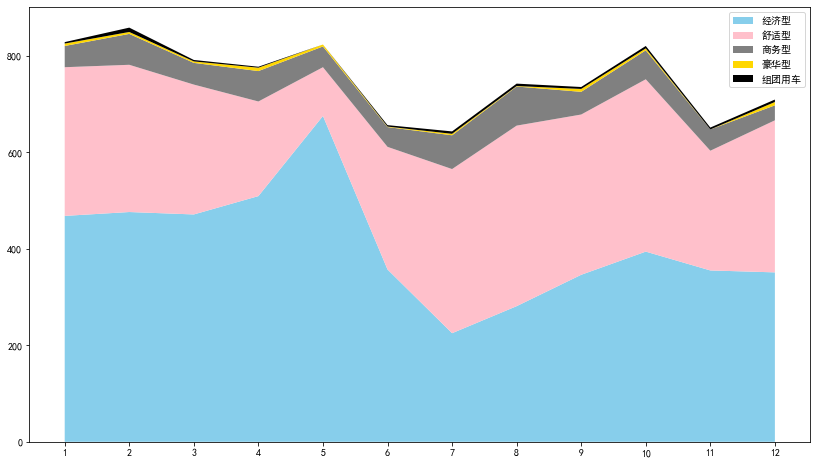

In [44]:
plt.figure(figsize=(14,8))
car_type_colors=['skyblue','pink','grey','gold','black']
x = df_service_type_each_month.xs(1).index
y_budget = se_order_car_type_each_month('经济型')
y_comfortable = se_order_car_type_each_month('舒适型')
y_business = se_order_car_type_each_month('商务型')
y_luxury = se_order_car_type_each_month('豪华型')
y_group = se_order_car_type_each_month('组团用车')
plt.stackplot(x,y_budget,y_comfortable,y_business,y_luxury,y_group,labels=order_car_type_list_short,colors=car_type_colors)
plt.xticks(x,labels=df_service_type_each_month.xs(1).index)
plt.legend(loc='best',labels=order_car_type_list_short)

In [45]:
y_comfortable > y_budget

order_month
1     False
2     False
3     False
4     False
5     False
6     False
7      True
8      True
9     False
10    False
11    False
12    False
dtype: bool

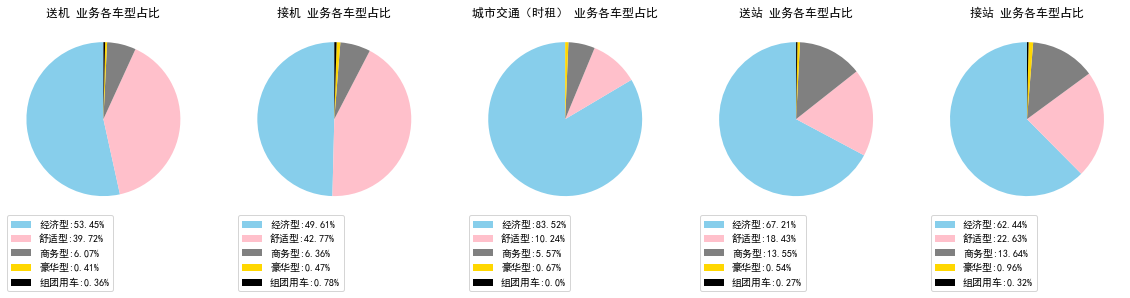

In [74]:
se_car_type_groupby_service_type = df_user_order_detail_1.groupby(['service_type_name','order_car_type_new']).count()['trade_order_id']
fig = plt.figure(figsize=(20,8))
for i,service_type in enumerate(service_type_name_list):
    aex = fig.add_subplot(1,5,(i+1))
    se_empty = pd.Series([0 for order_car_type in order_car_type_list_short],index=order_car_type_list_short)
    x_car_type_count = (se_empty+se_car_type_groupby_service_type[service_type]).fillna(0).sort_values(ascending=False)
    plt.pie(x_car_type_count,colors=car_type_colors,startangle=90)
    plt.title(f'{service_type} 业务各车型占比')
    plt.legend(labels=[f"{car_type}:{str(round((x_car_type_count[car_type]/x_car_type_count.sum())*100,2))}%" for m,car_type in enumerate(order_car_type_list_short)],
           bbox_to_anchor=(0,0),loc=2,borderaxespad=0)

##### 出租车服务订单全部用于城市交通（时租），7,8月订单数明显更高(6月订单仍在进行中，但已突出其它月份)；
##### 快车服务订单全部用于接机，除北京外，其他城市的订单极少（或没有）；
##### 在7,8月，舒适型车比经济型车更受欢迎，其他时间经济型订单数量更多；
##### 除开快车和出租车，在所有用车类型分布上，经济型和舒适型订单占大部分，商务型次之，豪华型和组团用车订单量很少；
##### 机场接送业务中，经济型和舒适型差距不算很大，而在车站业务中经济型订单数成倍多于舒适型；城市交通中经济型也远远高出其它车型；在车站接送中的商务型订单高于机场接送和城市交通
##### 整体订单数上接客服务多于送客服务，送客服务更多选择经济型，接客服务则更多选择其他类型

In [75]:
# 当日用车订单数
df_user_order_detail[df_user_order_detail['use_immediate']==1]['service_type_name'].value_counts()

接机          1887
城市交通（时租）    1183
送机           889
接站           374
送站           100
Name: service_type_name, dtype: int64

In [76]:
# 非当日用车订单数
df_user_order_detail[df_user_order_detail['use_immediate']==0]['service_type_name'].value_counts()

送机          2490
接机          2366
送站           269
接站           249
城市交通（时租）     193
Name: service_type_name, dtype: int64

In [77]:
df_user_order_detail[df_user_order_detail['is_bookdate_holiday']==0]['service_type_name'].value_counts()

接机          2950
送机          2235
城市交通（时租）     910
接站           418
送站           261
Name: service_type_name, dtype: int64

In [78]:
df_user_order_detail[df_user_order_detail['is_bookdate_holiday']==1]['service_type_name'].value_counts()

接机          1303
送机          1144
城市交通（时租）     466
接站           205
送站           108
Name: service_type_name, dtype: int64

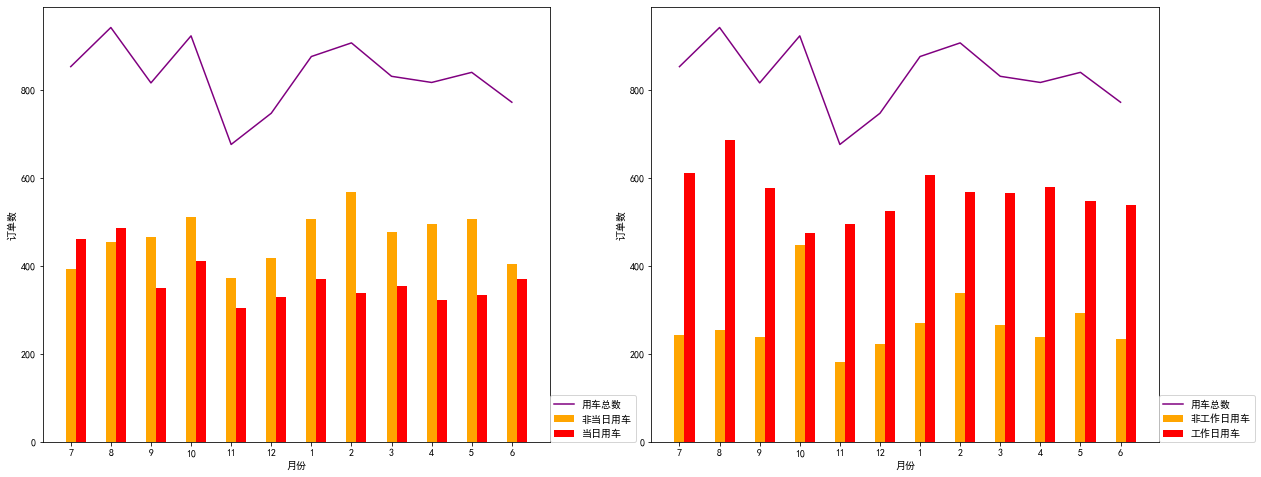

In [79]:
fig = plt.figure(figsize=(20,8))

axes1 = fig.add_subplot(121)
se_非当日用车笔数月份统计_用车日期顺序 = df_user_order_detail[df_user_order_detail['use_immediate']==0]['book_month'].value_counts()
se_当日用车笔数月份统计_用车日期顺序 = df_user_order_detail[df_user_order_detail['use_immediate']==1]['book_month'].value_counts()
y_0 = pd.concat([se_非当日用车笔数月份统计_用车日期顺序.sort_index()[6:],se_非当日用车笔数月份统计_用车日期顺序.sort_index()[:6]])
y_1 = pd.concat([se_当日用车笔数月份统计_用车日期顺序.sort_index()[6:],se_当日用车笔数月份统计_用车日期顺序.sort_index()[:6]])
y_2 = pd.concat([df_user_order_detail['book_month'].value_counts().sort_index()[6:],
                df_user_order_detail['book_month'].value_counts().sort_index()[:6]])
x1 = np.arange(1,13)
x2 = x1+0.25
plt.bar(x1,y_0,width=0.25,color='orange',tick_label=y_0.index.to_list(),label='非当日用车')
plt.bar(x2,y_1,width=0.25,color='red',label='当日用车')
plt.plot(x1,y_2,label='用车总数',color='purple')
plt.xlabel('月份')
plt.ylabel('订单数')
plt.xticks(ticks=x1,labels=y_0.index.to_list(),rotation=0)
plt.legend(bbox_to_anchor=(1,0),loc=3,borderaxespad=0)

axes1 = fig.add_subplot(122)
se_非工作日用车笔数月份统计_用车日期顺序 = df_user_order_detail[df_user_order_detail['is_bookdate_holiday']==1]['book_month'].value_counts()
se_工作日用车笔数月份统计_用车日期顺序 = df_user_order_detail[df_user_order_detail['is_bookdate_holiday']==0]['book_month'].value_counts()
y_3 = pd.concat([se_非工作日用车笔数月份统计_用车日期顺序.sort_index()[6:],se_非工作日用车笔数月份统计_用车日期顺序.sort_index()[:6]])
y_4 = pd.concat([se_工作日用车笔数月份统计_用车日期顺序.sort_index()[6:],se_工作日用车笔数月份统计_用车日期顺序.sort_index()[:6]])
x1 = np.arange(1,13)
x2 = x1+0.25
plt.bar(x1,y_3,width=0.25,color='orange',tick_label=y_0.index.to_list(),label='非工作日用车')
plt.bar(x2,y_4,width=0.25,color='red',label='工作日用车')
plt.plot(x1,y_2,label='用车总数',color='purple')
plt.xlabel('月份')
plt.ylabel('订单数')
plt.xticks(ticks=x1,labels=y_0.index.to_list(),rotation=0)
plt.legend(bbox_to_anchor=(1,0),loc=3,borderaxespad=0)

Text(0.5, 1.0, '非工作日用车各车型比例')

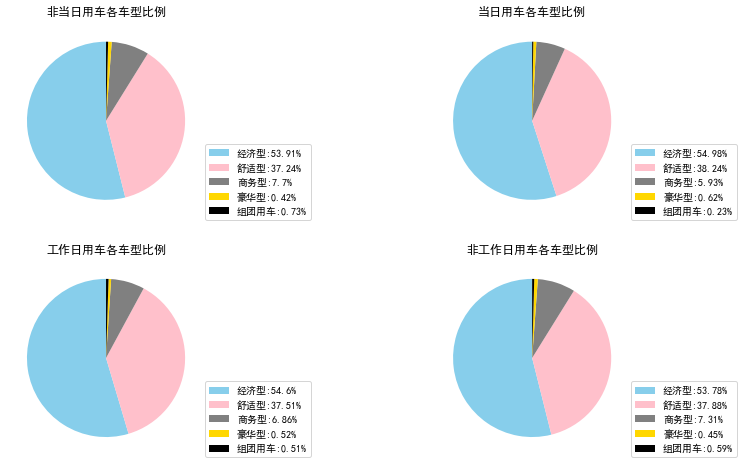

In [80]:
fig = plt.figure(figsize=(14,8))
axes1 = fig.add_subplot(2,2,1)
x_not_use_immediate = df_user_order_detail_1[df_user_order_detail_1['use_immediate']==0]['order_car_type_new'].value_counts().sort_values(ascending=False)
plt.pie(x_not_use_immediate,colors=car_type_colors,startangle=90)
plt.legend(labels=[f"{car_type}:{str(round((x_not_use_immediate[car_type]/x_not_use_immediate.sum())*100,2))}%" for m,car_type in enumerate(order_car_type_list_short)],
           bbox_to_anchor=(1,0),loc=3,borderaxespad=0)
plt.title('非当日用车各车型比例')

axes2 = fig.add_subplot(2,2,2)
x_use_immediate = df_user_order_detail_1[df_user_order_detail_1['use_immediate']==1]['order_car_type_new'].value_counts().sort_values(ascending=False)
plt.pie(x_use_immediate,colors=car_type_colors,startangle=90)
plt.legend(labels=[f"{car_type}:{str(round((x_use_immediate[car_type]/x_use_immediate.sum())*100,2))}%" for m,car_type in enumerate(order_car_type_list_short)],
           bbox_to_anchor=(1,0),loc=3,borderaxespad=0)
plt.title('当日用车各车型比例')

axes3 = fig.add_subplot(2,2,3)
x_booked_workday = df_user_order_detail_1[df_user_order_detail_1['is_bookdate_holiday']==0]['order_car_type_new'].value_counts().sort_values(ascending=False)
plt.pie(x_booked_workday,colors=car_type_colors,startangle=90)
plt.legend(labels=[f"{car_type}:{str(round((x_booked_workday[car_type]/x_booked_workday.sum())*100,2))}%" for m,car_type in enumerate(order_car_type_list_short)],
           bbox_to_anchor=(1,0),loc=3,borderaxespad=0)
plt.title('工作日用车各车型比例')

axes4 = fig.add_subplot(2,2,4)
x_booked_holiday = df_user_order_detail_1[df_user_order_detail_1['is_bookdate_holiday']==1]['order_car_type_new'].value_counts().sort_values(ascending=False)
plt.pie(x_not_use_immediate,colors=car_type_colors,startangle=90)
plt.legend(labels=[f"{car_type}:{str(round((x_booked_holiday[car_type]/x_booked_holiday.sum())*100,2))}%" for m,car_type in enumerate(order_car_type_list_short)],
           bbox_to_anchor=(1,0),loc=3,borderaxespad=0)
plt.title('非工作日用车各车型比例')

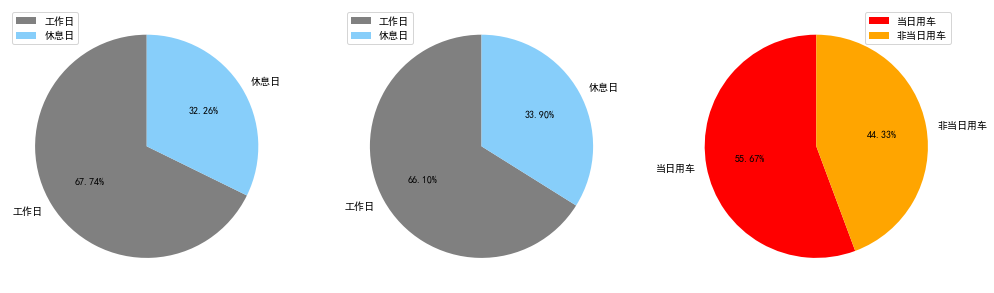

In [81]:
fig = plt.figure(figsize=(17,6))
color_list = [['gray','lightskyblue'],['gray','lightskyblue'],['red','orange']]
labels = [['工作日','休息日'],['工作日','休息日'],['当日用车','非当日用车']]
# x = np.arange(0, 100)  
for i,col in enumerate(['is_bookdate_holiday','is_orderdate_holiday','use_immediate']):
    axes = fig.add_subplot(1,3,int(i+1))
    x = df_user_order_detail[col].value_counts()
    plt.pie(x,autopct='%1.2f%%',labels=labels[i],colors=color_list[i],startangle=90)
    axes.legend(loc='best')
plt.show()

##### 工作日用车多于非工作日用车(无论哪种业务类型)；
##### 工作日和非工作日及是否当日用车对经济型，舒适型，商务型和豪华型车选择影响有限，但组团用车在非工作日提升较多，并且多为非当日用车；
##### 当日用车接客订单数大于送客订单数，非当日用车则反之；
##### 城市交通订单中大多数为当日用车；6,7,8月外，当日用车订单数有所下降（疑似天气转凉，城市交通用车需求下降所致）；